In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
import nltk
from nltk.tokenize import word_tokenize, MWETokenizer

# got tired of warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:


# API URL
api_url = "https://storage.googleapis.com/gsearch_share/gsearch_jobs.csv"

# Columns to include in the DataFrame
columns = ['index', 'title', 'company_name', 'location', 'via', 'description', 'extensions', 'job_id', 'thumbnail',
           'posted_at', 'schedule_type', 'work_from_home', 'salary', 'search_term', 'date_time', 'search_location',
           'commute_time', 'salary_pay', 'salary_rate', 'salary_avg', 'salary_min', 'salary_max', 'salary_hourly',
           'salary_yearly', 'salary_standardized', 'description_tokens']

# Read data from the API and select specific columns

jobs_all = pd.read_csv(api_url, error_bad_lines=False).replace("'","", regex=True)
# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)








In [3]:

# converts the 'date_time' column of the DataFrame to datetime format
#using the pd.to_datetime() function.
#This allows for easier manipulation and analysis of date and time data.
jobs_all.date_time = pd.to_datetime(jobs_all.date_time) 

#The axis=1 parameter indicates that columns should be dropped
jobs_all = jobs_all.drop(labels=['Unnamed: 0', 'index'], axis=1, errors='ignore')

#It processes the 'description_tokens' column 
#by removing the square brackets ([]) 
#around the text and splitting the string into a list of tokens
# This is done to transform the textual representation of tokens
# into an actual list of tokens.
jobs_all.description_tokens = jobs_all.description_tokens.str.strip("[]").str.split(",")

In [4]:
print("Big Query Statistics:")
print("---------------------")
#the dataset size.
print(f" Rows of data: {len(jobs_all)}")

repeat_jobs = jobs_all.job_id.value_counts()
try:
    repeat_jobs = repeat_jobs[repeat_jobs>1].index[0]
    repeat_jobs = len(repeat_jobs)
except IndexError:
    repeat_jobs = "None"
print(f" Number jobs repeated: {repeat_jobs}")

first_date = jobs_all.date_time.dt.date.min()
today_date = datetime.date.today() #+ datetime.timedelta(days=2) # test function works

#calculates the count of job listings for each date
date_count = pd.DataFrame(jobs_all.date_time.dt.date.value_counts())

#compares the range of dates from the earliest date to today's date with 
#the dates available in the date_count DataFrame
#to identify any missing dates
missing_dates = list(pd.date_range(start=first_date, end=today_date).difference(date_count.index))
if len(missing_dates) > 0:
    print(" Missing data for following dates:")
    for date in missing_dates:
        print(date)
else:
    print(f" No missing dates of data since inception of: {first_date}")


#calculates the number of days between
#today's date and the day before the earliest date in the dataset
delta_days = (today_date - (first_date - datetime.timedelta(days=2))).days # first day was actually day prior but UTC

#calculates the average number of jobs
#per day by dividing the total number
#of jobs by delta_days, rounds the result
jobs_day = round(len(jobs_all)/delta_days)
print(f" Average number of jobs per day: {jobs_day}")
print(f" Collecting data for {delta_days} days now...")

Big Query Statistics:
---------------------
 Rows of data: 19851
 Number jobs repeated: 908
 Missing data for following dates:
2022-12-28 00:00:00
2023-05-22 00:00:00
2023-05-23 00:00:00
 Average number of jobs per day: 93


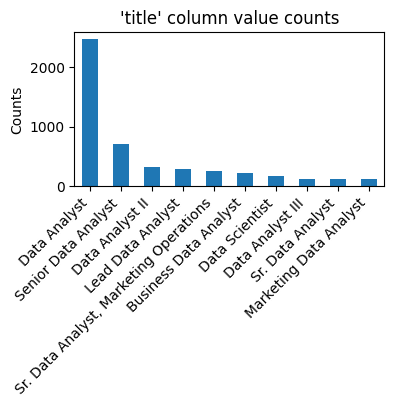

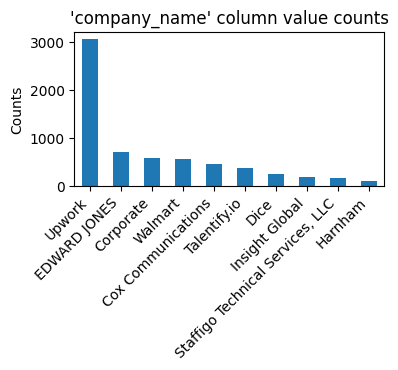

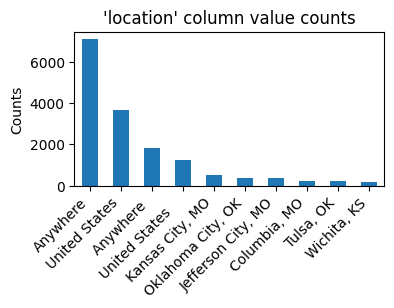

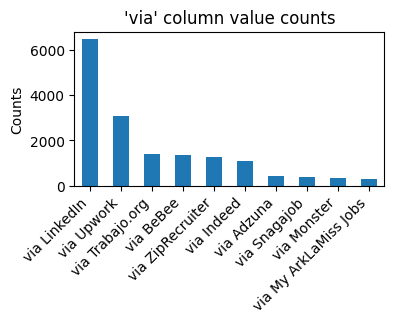

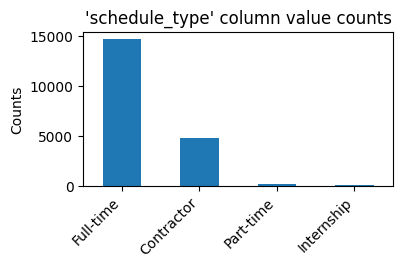

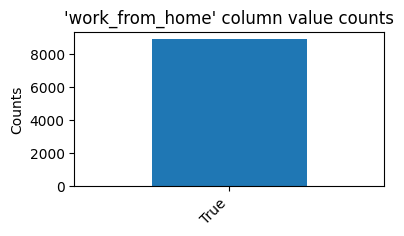

In [5]:
#takes two parameters: column (the column name to analyze) 
#and topn (the number 
#of top values to display in the plot, with a default value of 10).
def eda_plot(column, topn=10):
    plt.figure(figsize=(4, 2))

#It uses the value_counts() method on the specified column
#of the jobs_all DataFrame to count the occurrences of
#each unique value and
#selects the top topn values using nlargest(topn).
    jobs_all[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 45, ha='right')
    plt.show()

columns = ['title', 'company_name', 'location', 'via', 'schedule_type', 'work_from_home']

for column in columns:
    eda_plot(column)

In [6]:
# Separate 'salary' column into that for min max avg and rate (e.g., hourly)

#splits the 'salary' column into two separate columns
#'salary_pay' and 'salary_rate', based on the space character.
jobs_all[['salary_pay', 'salary_rate']] = jobs_all.salary.str.split(' ', 1, expand=True)

#removes commas, dollar signs, and spaces from the 'salary_pay' 
jobs_all.salary_pay = jobs_all.salary_pay.str.replace(',', '').str.replace('$', '').str.replace(' ', '')

#creates a new column, 'salary_avg', which initially contains
#the values from 'salary_pay'. If the 'salary_pay' column 
#contains the character "–" (U+2013)
#indicating a range, the corresponding value in 'salary_avg' 
#is set to NaN.
jobs_all['salary_avg'] = np.where(jobs_all.salary_pay.str.contains("–"), np.NaN, jobs_all.salary_pay)  # The character U+2013 "–" could be confused with the character U+002d "-", which is more common in source code. Adjust settings
jobs_all['salary_min'] = np.where(jobs_all.salary_pay.str.contains("–"), jobs_all.salary_pay, np.NaN)
jobs_all[['salary_min', 'salary_max']] = jobs_all.salary_min.str.split("–", 1, expand=True)



for column in ['salary_avg', 'salary_min', 'salary_max']:
    #checks if the values in the current column contain the letter "K"
    #indicating thousands. If so, it removes the "K" 
    #character and multiplies the resulting values by 1000
    jobs_all[column] = np.where(jobs_all[column].str.contains("K"), jobs_all[column].str.replace("K", "").astype(float) * 1000 , jobs_all[column] )
jobs_all['salary_avg'] = np.where(~jobs_all.salary_min.isnull(), (jobs_all.salary_min.astype(float) + jobs_all.salary_max.astype(float))/2 , jobs_all.salary_avg)
jobs_all['salary_hourly'] = np.where(jobs_all.salary_rate == 'an hour', jobs_all.salary_avg.astype(float), np.NaN)
jobs_all['salary_yearly'] = np.where(jobs_all.salary_rate == 'a year', jobs_all.salary_avg.astype(float), np.NaN)

# Standardize salary to all be annual
jobs_all['salary_standardized'] = np.NaN

#defines a dictionary, 'salary_rate', which maps the salary rate types 
#('a year', 'an hour', 'a month') to their corresponding conversion factors
salary_rate = {'a year': 1, 'an hour': 2080, 'a month': 12}

#updates the 'salary_standardized' column based on the salary rate.
#If the 'salary_rate' matches the current key in the loop
#it multiplies the 'salary_avg' values by the corresponding index (conversion factor)
#and assigns the result to 'salary_standardized'.
#Otherwise, it keeps the original values in 'salary_standardized'.
for key, index in salary_rate.items():
    jobs_all.salary_standardized = np.where(jobs_all.salary_rate == key, jobs_all.salary_avg.astype(float) * index, jobs_all.salary_standardized)

# Used to check results as built above
salary_df = jobs_all[~jobs_all.salary.isnull()]
salary_df = salary_df[['company_name', 'salary', 'salary_pay', 'salary_rate', 'salary_avg', 'salary_min', 'salary_max', 'salary_standardized', 'salary_hourly', 'salary_yearly']] #, 'salary_min', 'salary_max']
pd.set_option('display.max_rows', salary_df.shape[0]+1)
salary_df.head(10)

,company_name,salary,salary_pay,salary_rate,salary_avg,salary_min,salary_max,salary_standardized,salary_hourly,salary_yearly
6,Upwork,37–75 an hour,37–75,an hour,56.0,37,75,116480.0,56.0,NaN
13,Charles River Laboratories,65K–75K a year,65K–75K,a year,70000.0,65000.0,75000.0,70000.0,NaN,70000.0
23,Charles River Laboratories,65K–75K a year,65K–75K,a year,70000.0,65000.0,75000.0,70000.0,NaN,70000.0
33,Charles River Laboratories,65K–75K a year,65K–75K,a year,70000.0,65000.0,75000.0,70000.0,NaN,70000.0
43,Insight Global,40–45 an hour,40–45,an hour,42.5,40,45,88400.0,42.5,NaN
44,Apex Systems,30 an hour,30,an hour,30,NaN,None,62400.0,30.0,NaN
46,Upwork,20–50 an hour,20–50,an hour,35.0,20,50,72800.0,35.0,NaN
48,Global Network Technologies,32–34 an hour,32–34,an hour,33.0,32,34,68640.0,33.0,NaN
49,Kelly Services,35 an hour,35,an hour,35,NaN,None,72800.0,35.0,NaN
52,Progressive,56.3K–90.8K a year,56.3K–90.8K,a year,73550.0,56300.0,90800.0,73550.0,NaN,73550.0


Text(0.5, 0, '($USD/hr) Hourly Pay')

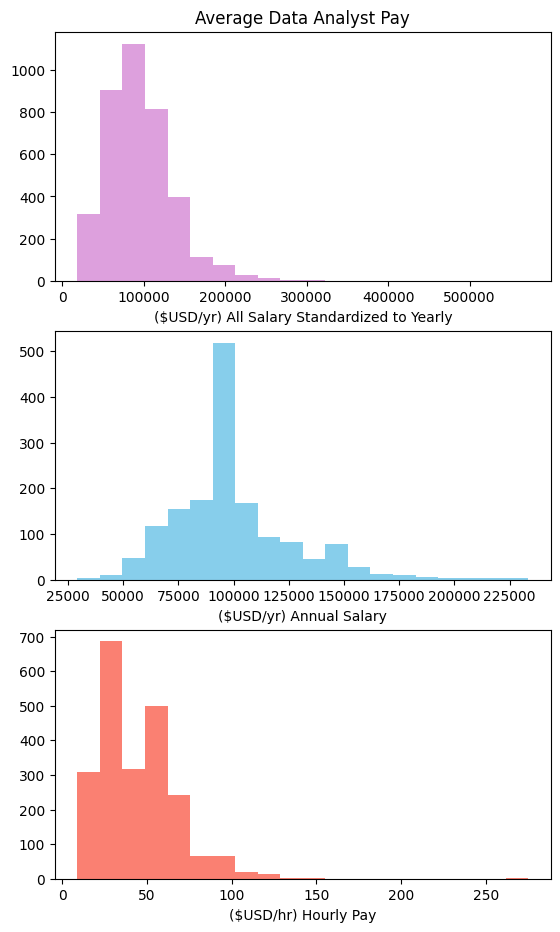

In [7]:
# plt.figure(figsize=(10, 2))
#creates a figure with three subplots arranged vertically. 
fig, axs = plt.subplots(3)
fig.set_figheight(11)

#creates a histogram in the first subplot 
#using the 'salary_standardized' column from the jobs_all DataFrame. 
#The histogram is divided into 20 bins, and the bars are colored in 'plum'.
axs[0].hist(jobs_all.salary_standardized, bins = 20, color = 'plum')
axs[0].set_title("Average Data Analyst Pay")
axs[0].set_xlabel("($USD/yr) All Salary Standardized to Yearly")

#creates a histogram in the second subplot
#using the 'salary_yearly' column from the jobs_all DataFrame. 
#The histogram is divided into 20 bins
#and the bars are colored in 'skyblue'.
axs[1].hist(jobs_all.salary_yearly, bins = 20, color = 'skyblue')
axs[1].set_xlabel("($USD/yr) Annual Salary")


axs[2].hist(jobs_all.salary_hourly, bins = 20, color = 'salmon')
axs[2].set_xlabel("($USD/hr) Hourly Pay")


In [8]:
# Downloads the necessary NLTK tokenizer by running 
nltk.download('punkt')

# Picked out keywords based on all keywords (only looked words with 100+ occurrences)
keywords_programming = [
'sql', 'python', 'r', 'c', 'c#', 'javascript', 'js',  'java', 'scala', 'sas', 'matlab', 
'c++', 'c/c++', 'perl', 'go', 'typescript', 'bash', 'html', 'css', 'php', 'powershell', 'rust', 
'kotlin', 'ruby',  'dart', 'assembly', 'swift', 'vba', 'lua', 'groovy', 'delphi', 'objective-c', 
'haskell', 'elixir', 'julia', 'clojure', 'solidity', 'lisp', 'f#', 'fortran', 'erlang', 'apl', 
'cobol', 'ocaml', 'crystal', 'javascript/typescript', 'golang', 'nosql', 'mongodb', 't-sql', 'no-sql',
'visual_basic', 'pascal', 'mongo', 'pl/sql',  'sass', 'vb.net', 'mssql', 
]

keywords_libraries = [
'scikit-learn', 'jupyter', 'theano', 'openCV', 'spark', 'nltk', 'mlpack', 'chainer', 'fann', 'shogun', 
'dlib', 'mxnet', 'node.js', 'vue', 'vue.js', 'keras', 'ember.js', 'jse/jee',
]
keywords_analyst_tools = [
'excel', 'tableau',  'word', 'powerpoint', 'looker', 'powerbi', 'outlook', 'azure', 'jira', 'twilio',  'snowflake', 
'shell', 'linux', 'sas', 'sharepoint', 'mysql', 'visio', 'git', 'mssql', 'powerpoints', 'postgresql', 'spreadsheets',
'seaborn', 'pandas', 'gdpr', 'spreadsheet', 'alteryx', 'github', 'postgres', 'ssis', 'numpy', 'power_bi', 'spss', 'ssrs', 
'microstrategy',  'cognos', 'dax', 'matplotlib', 'dplyr', 'tidyr', 'ggplot2', 'plotly', 'esquisse', 'rshiny', 'mlr',
'docker', 'linux', 'jira',  'hadoop', 'airflow', 'redis', 'graphql', 'sap', 'tensorflow', 'node', 'asp.net', 'unix',
'jquery', 'pyspark', 'pytorch', 'gitlab', 'selenium', 'splunk', 'bitbucket', 'qlik', 'terminal', 'atlassian', 'unix/linux',
'linux/unix', 'ubuntu', 'nuix', 'datarobot',
]

keywords_cloud_tools = [
'aws', 'azure', 'gcp', 'snowflake', 'redshift', 'bigquery', 'aurora',
]


keywords = keywords_programming + keywords_libraries + keywords_analyst_tools + keywords_cloud_tools 

jobs_all = jobs_all[jobs_all.description.notnull()] # filter out null values
jobs_all = jobs_all.reset_index() # throwing index issues if don't reset index
# jobs_all = jobs_all.head(10) 

jobs_all['description_tokens'] = ""

for index, row in jobs_all.iterrows():
    # lowercase words
    detail = row.description.lower()
    # Tokenizes the words using NLTK's word_tokenize
    detail = word_tokenize(detail)
    # handle multi-word tokenization (e.g., 'Power BI')
    multi_tokens = [('power', 'bi'), ('data', 'lake'), ('data', 'lakes'), ('machine', 'learning'), ('objective', 'c'),
                    ('visual', 'basic')]
    tokenizer = MWETokenizer(multi_tokens)
    detail = tokenizer.tokenize(detail)
    # remove duplicates
    detail = list(set(detail))
    # Filters for tokens that are present in the defined keywords lists.
    detail = [word for word in detail if word in keywords] 
    # Replaces certain tokens with their 
    #corresponding values in the replace_tokens dictionary.
    replace_tokens = {'powerbi' : 'power_bi', 'spreadsheets': 'spreadsheet'}
    for key, value in replace_tokens.items():
        detail = [d.replace(key, value) for d in detail]
    # add to details list # row.description_tokens = detail
    jobs_all.at[index, 'description_tokens'] = detail

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
def filtered_keywords(jobs_filtered, keywords, title="Keyword Analysis", head=10):
    # get keywords in a column
    count_keywords = pd.DataFrame(jobs_filtered.description_tokens.sum()).value_counts().rename_axis('keywords').reset_index(name='counts')

    # get frequency of occurence of word (as word only appears once per line)
    length = len(jobs_filtered) # number of job postings
    count_keywords['percentage'] = 100 * count_keywords.counts / length

    # plot the results
    count_keywords = count_keywords[count_keywords.keywords.isin(keywords)]
    count_keywords = count_keywords.head(head)
    g = plt.bar(x="keywords", height="percentage", data=count_keywords , color=np.random.rand(len(count_keywords.keywords), 3))
    plt.xlabel("")
    plt.ylabel("Likelyhood to be in job posting (%)")
    plt.xticks(rotation = 45, ha='right')
    plt.title(title) 
    plt.show(g)
    print(count_keywords)

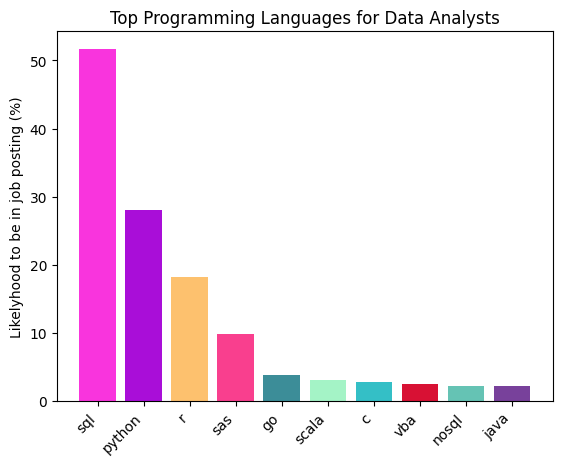

   keywords  counts  percentage
0       sql   10260   51.685054
3    python    5571   28.064077
5         r    3610   18.185482
6       sas    1965    9.898746
15       go     744    3.747922
20    scala     599    3.017480
21        c     565    2.846204
25      vba     489    2.463352
27    nosql     448    2.256813
28     java     442    2.226588


In [10]:
filtered_keywords(jobs_all, keywords_programming, title="Top Programming Languages for Data Analysts")

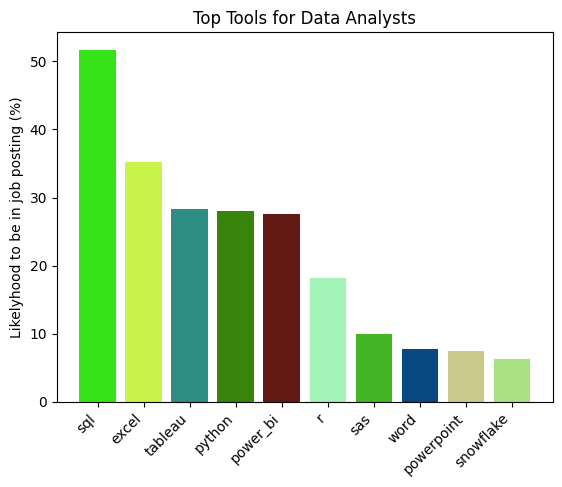

     keywords  counts  percentage
0         sql   10260   51.685054
1       excel    6995   35.237520
2     tableau    5612   28.270616
3      python    5571   28.064077
4    power_bi    5488   27.645962
5           r    3610   18.185482
6         sas    1965    9.898746
7        word    1527    7.692308
8  powerpoint    1496    7.536144
9   snowflake    1236    6.226387


In [11]:
filtered_keywords(jobs_all, keywords, title="Top Tools for Data Analysts")